# Detector 2.0 - With More Tonal Noise Examples

Added Ulu23 into the training data, and added 200 more noise samples of bearded seal noise & ice 

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import shutil
import os
import glob
import csv
import time
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix as confusion_matrix_sklearn
import scipy

from ketos.data_handling import selection_table as sl
import ketos.data_handling.database_interface as dbi
from ketos.data_handling.parsing import load_audio_representation
from ketos.data_handling.data_feeding import BatchGenerator
from ketos.neural_networks.resnet import ResNetInterface
from ketos.audio.audio_loader import AudioFrameLoader, AudioLoader, SelectionTableIterator
from ketos.audio.spectrogram import MagSpectrogram
from ketos.neural_networks.dev_utils.detection import batch_load_audio_file_data, filter_by_threshold, filter_by_label, merge_overlapping_detections
from ketos.data_handling.data_feeding import JointBatchGen

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print('done importing packages')

done importing packages


C:\Users\kzammit\Miniconda3\envs\ketos_env\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Functions

In [2]:
def drop_rows(file_durations, table):

    drop = []

    print('cleaning training table of original length ' + str(len(table)))

    for idex, row in table.iterrows():
    
        # filename is row[0], end time is idex.end
        index = file_durations.loc[file_durations['filename'] == row.name[0]].index
        duration = file_durations['duration'][index].values[0]
    
        if duration < row.end:
            # drop the row corresponding to that sel_id and filename from the dataframe
            drop.append(idex)
    
        if row.start < 0:
            drop.append(idex)
    
    print('Number of rows to drop (note, one entry may be in list twice): ' + str(len(drop)))

    return drop

In [3]:
def compute_detections(labels, scores, threshold=0.5):

    # Compute the positive scores above threshold, 1 if it is above threshold, 0 if it is not 
    predictions = np.where(scores >= threshold, 1,0)

    # TP: Does the annotated label match the prediction above threshold? Bc "scores" is defined as the positive threshold, this represents TP
    TP = tf.math.count_nonzero(predictions * labels).numpy()

    # TN: Negative score is "predictions - 1" bc predictions was for the positive result, labels-1 so that the negatives are multiplied by 1
    TN = tf.math.count_nonzero((predictions - 1) * (labels - 1)).numpy()

    # And so on 
    FP = tf.math.count_nonzero(predictions * (labels - 1)).numpy()
    FN = tf.math.count_nonzero((predictions - 1) * labels).numpy()

    return predictions, TP, TN, FP, FN

# Ran Already - for History

## Create Annotation Files from Selection Tables

In [ ]:
def concat_annot(sel_tables_folder):
    """

    :param sel_tables_folder:
    :return:
    """

    files = glob.glob(sel_tables_folder + '\*.txt')

    for fdex, file in enumerate(files):

        df = pd.read_csv(file, sep='\t', encoding='latin1')
        df = df.rename(columns={'KZ Keep? (Y/X/M)': "keep_drop"})
        #df = df[df.keep_drop == 'Y']

        if 'CB' in file:
            site_name = file.split('\\')[-1].split('_')[0]
        elif 'Ulukhaktok' in file:
            site_name = file.split('\\')[-1].split('_')[0] + '.' + file.split('\\')[-1].split('_')[1]
        elif 'ulu.2022' in file:
            site_name = 'ulu.2022'
        elif 'ulu.2023' in file:
            site_name = file.split('\\')[-1].split('_')[0]
        else:
            site_name = file.split('\\')[-1].split('_')[0] + '.' + file.split('\\')[-1].split('_')[1] + '.' + \
                        file.split('\\')[-1].split('_')[2]

        df.insert(0, 'site_name', site_name)

        if fdex == 0:
            df_all = df
        else:
            df_all = pd.concat([df_all, df], ignore_index=True)

    return df_all


def format_annot(df, output_name):
    """

    :param df:
    :param output_name:
    :return:
    """

    writer = pd.ExcelWriter(output_name, engine='xlsxwriter')

    # set start and end time of annotation
    df['start'] = df['File Offset (s)']
    df['Delta Time (s)'] = df['End Time (s)'] - df['Begin Time (s)']
    df['end'] = df['File Offset (s)'] + df['Delta Time (s)']

    # rename the begin-path column for easier reference
    df = df.rename(columns={'Begin Path': "filename"})

    # initiate an empty df for the complete annotations
    df_annot = pd.DataFrame(columns=df.columns)

    # get the names of each unique wav file
    unique_files = df['filename'].unique()

    # loop through each unique wav, and set the annot_id for each one
    for fdex, wavF in enumerate(unique_files):

        # create a temp df that only has the entries for this wav file
        df_temp = df[df.filename == wavF]

        # reset the index
        df_temp = df_temp.reset_index(drop=True)

        # set the annot_id column to 'not set' initially
        df_temp['annot_id'] = 'not set'

        # start the counter at 0
        annot_id = 0

        # for the number of annotations with this wav file,
        for ii in range(0, len(df_temp)):
            # set the annot_id incrementally
            df_temp['annot_id'][ii] = annot_id
            annot_id += 1

        # append this wav files info to the df_annot df
        df_annot = pd.concat([df_annot, df_temp], ignore_index=True)

    #df_annot = df_annot.rename(columns={'Call Type': "call_type"})
    df_annot = df_annot.rename(columns={'Type': "call_type"})

    df_annot_sub = df_annot[['site_name', 'Selection', 'filename', 'start', 'end', 'annot_id']]

    df_annot_sub['label'] = df_annot['call_type']

    df_annot_sub.to_excel(writer, index=False)
    writer.close()

    return df_annot_sub

if __name__ == "__main__":

    output_dir = r'E:\detector_2\annots\CierrasFiles\selection_tables\annot_format'

    # path to folder with selection tables
    sel_table_path = r'E:\detector_2\annots\CierrasFiles\selection_tables'

    # name of output selection tables excel workbook (just for reference)
    output_file_trim = output_dir + r'\all_annotations.xlsx'

    # call the trim_tables function, and set the output excel workbook file name
    # note I commented out the intermediate output file
    all_annot_orig = concat_annot(sel_table_path)

    # output an Excel sheet with all the annotations before splitting
    formatted_table = format_annot(all_annot_orig, output_name=output_dir + r'\all_annotations_20240821.xlsx')

## Convert Annot Tables to Ketos 1-s Selections

In [3]:
annot_neg = pd.read_excel(r'E:\detector_2\annots\CierrasFiles\selection_tables\annot_format\all_annotations_20240821.xlsx')
std_annot_neg = sl.standardize(table=annot_neg, trim_table=True)
neg_add = sl.select(annotations=std_annot_neg, length=1.0, step=1, min_overlap=0.001, center=False, label=0)
neg_add['Class'] = 'BS/I'
neg_add.to_excel(r'E:\detector_2\annots\CierrasFiles\selection_tables\annot_format\ice_bs_cb_sel_table.xlsx')

## Plot Spectrograms

Manually created "-plot" version of the selection tables with a new "Title" column for file naming

In [6]:
import pandas as pd
import seaborn as sns
pd.options.mode.chained_assignment = None
import sys
import matplotlib.pyplot as plt
import matplotlib
from ketos.data_handling import selection_table as sl
from ketos.audio.spectrogram import MagSpectrogram
from ketos.audio.audio_loader import AudioLoader, SelectionTableIterator
import os
import glob
import json

def load_audio_seg(annot_file, spec_file, data_dir):
    """
    Plot spectrograms for review
    :param annot_file: annotation file (xlsx)
    :param spec_file: spectrogram file
    :param data_dir: directory where data is stored (main level)
    :return:
    """

    annot = pd.read_excel(annot_file)

    # something up with loading in the spectro file
    f = open(spec_file)
    spec_info = json.load(f)
    rep = spec_info['spectrogram']

    # deal with merging of cells in the annotations table
    for ii in range(0, len(annot)):
        if type(annot.loc[ii][0]) == str:
            filename = annot.loc[ii][0]
        else:
            filename = annot['filename'][ii]

    # standardize tables
    annot = annot.ffill()
    annot_std = sl.standardize(table=annot)
    print('table standardized? ' + str(sl.is_standardized(annot_std)))

    # create a generator for iterating over all the selections
    generator = SelectionTableIterator(data_dir=data_dir, selection_table=annot_std)

    # Create a loader by passing the generator and the representation to the AudioLoader
    loader = AudioLoader(selection_gen=generator, representation=MagSpectrogram, representation_params=rep, pad=False)

    # print number of segments
    print('Total number of segments is ' + str(loader.num()))
    annots = float(loader.num())

    return annots, loader


def plot_spectrogram(annot, loader, output_dir):

    font = {'family': 'sans',
            'weight': 'normal',
            'size': 20}
    matplotlib.rc('font', **font)

    for ii in range(0, int(annot)):
        spec = next(loader)
        x = spec.get_data()
        extent = (0., spec.duration(), spec.freq_min(), spec.freq_max())  # axes ranges
        plt.imshow(x.T, aspect='auto', origin='lower', extent=extent, vmin=None, vmax=None, cmap='Greys')
        #fig = spec.plot(label_in_title=False)
        path = output_dir
        figname = path + "\\" + str(ii) + '-' + str(loader.selection_gen.sel.Title[ii]) + '.png'
        #plt.title(loader.selection_gen.sel.Title[ii])
        plt.savefig(figname, bbox_inches='tight')
        plt.close()


if __name__ == "__main__":

    annot_folder = r'E:\detector_2\annots\CierrasFiles\selection_tables\annot_format'
    #annot_folder = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\detections\ensemble\plotting'
    data_dir = r"D:\ringed-seal-data"
    spec_file = r'E:\detector_2\spec_config_100-1200Hz-0.032-hamm-normalized.json'

    annot_folders = [annot_folder]

    annot_files = ['ice_bs_cb_sel_table-plot.xlsx']
    #annot_files = ['ulu2023-dets-to-plot-formatted.xlsx']

    output_dirs = [r'E:\detector_2\annots\CierrasFiles\selection_tables\annot_format\spectros']
    #output_dirs = [r'E:\baseline-with-normalization-reduce-tonal\ulu2023\detections\ensemble\plotting']

    for idx, folder in enumerate(annot_folders):

        # create an audioloader with the spectrograms
        annot, loader = load_audio_seg(annot_folders[idx] + '\\' + annot_files[idx], spec_file, data_dir)

        # take audio segments and create spectrogram representation
        plot_spectrogram(annot, loader, output_dirs[idx])


table standardized? True
Total number of segments is 274


## Join Negatives 

In order to join the new negatives, we need to make sure there are no duplicates, remove any found, and update the annot id 

In [17]:
folder = r"E:\detector_2\annots"

files = glob.glob(folder + "/*.xlsx")

new_negs = r'E:\detector_2\annots\CierrasFiles\selection_tables\annot_format\moved-here'

join_files = glob.glob(new_negs + '/*.xlsx')

In [18]:
output_dir = r'E:\detector_2\annots'

names = ['CB']

for idex, file in enumerate(files):

    annots = pd.read_excel(file)
    df_annot = pd.DataFrame(columns=annots.columns)
    annots = annots.ffill()
    annots['end'] = annots['start'] + 1
    annots = annots.rename(columns={"annot_id": "sel_id"})

    join_file = pd.read_excel(join_files[idex])
    join_file = join_file.ffill()
    joined = pd.concat([join_file, annots])

    # See if there were duplicates bc generated separately
    joined['dup'] = joined.duplicated(subset=['filename', 'sel_id'])
    joined = joined.sort_values(by=['filename'])

    # Fix the selection id's for added ones... just gunna redo them, durg
    # get the names of each unique wav file
    unique_files = joined['filename'].unique()

    # loop through each unique wav, and set the annot_id for each one
    for fdex, wavF in enumerate(unique_files):

        # create a temp df that only has the entries for this wav file
        df_temp = joined[joined.filename == wavF]

        # reset the index
        df_temp = df_temp.reset_index(drop=True)

        # set the annot_id column to 'not set' initially
        df_temp['annot_id'] = 'not set'

        # start the counter at 0
        annot_id = 0

        # for the number of annotations with this wav file,
        for ii in range(0, len(df_temp)):
            # set the annot_id incrementally
            df_temp['annot_id'][ii] = annot_id
            annot_id += 1

        df_annot = pd.concat([df_annot, df_temp], ignore_index=True)

    df_annot = df_annot.drop(columns={'sel_id'})
    df_annot = df_annot.rename(columns={"annot_id": "sel_id"})

    df_annot.to_excel(output_dir + '\\' + names[idex] + '-negs-joined.xlsx', index=False)

test


# Create Detector

## Create New Database

In [20]:
main_folder = r'E:\detector_2'
spectro_file = main_folder + '\\' + 'spec_config_100-1200Hz-0.032-hamm-normalized.json'
recipe_file = main_folder + '\\' + 'resnet_recipe-1.json'
pos_folder = main_folder + '\\' + r'annots\pos'
neg_folder = main_folder + '\\' + r'annots\neg'
file_durations_file = main_folder + '\\' + 'all_file_durations_complete.xlsx'
file_durations = pd.read_excel(file_durations_file)

db_name = main_folder + '\\' + 'detector-2-db.h5'
temp_folder = main_folder + '\\' + 'rs-temp'
data_folder = r'D:\ringed-seal-data'

In [7]:
ulu2022_vals_pos = [1036, 293, 147]
ulu2023_vals_pos = [358, 102, 51]
ulu_vals_pos = [672, 192, 91]
kk_vals_pos = [1354, 387, 183]
cb_vals_pos = [134, 39, 17]

ulu2022_vals_neg = [1034, 296, 146]
ulu2023_vals_neg = [358, 103, 50]
ulu_vals_neg = [669, 191, 95]
kk_vals_neg = [1347, 385, 192]
cb_vals_neg = [326, 93, 45]

In [8]:
# negatives tables and standarize for ketos
ulu_neg = pd.read_excel(neg_folder + '\\' + 'ULU-negs-joined.xlsx')
ulu_neg = ulu_neg.ffill()
ulu_neg = sl.standardize(table=ulu_neg)
print('Negatives standardized? ' + str(sl.is_standardized(ulu_neg)))

ulu2022_neg = pd.read_excel(neg_folder + '\\' + 'ULU2022-negs-joined.xlsx')
ulu2022_neg = ulu2022_neg.ffill()
ulu2022_neg = sl.standardize(table=ulu2022_neg)
print('Negatives standardized? ' + str(sl.is_standardized(ulu2022_neg)))

ulu2023_neg = pd.read_csv(neg_folder + '\\' + 'ULU2023-negs.csv')
ulu2023_neg = ulu2023_neg.ffill()
ulu2023_neg = sl.standardize(table=ulu2023_neg)
print('Negatives standardized? ' + str(sl.is_standardized(ulu2023_neg)))

kk_neg = pd.read_excel(neg_folder + '\\' + 'KK-negs-joined.xlsx')
kk_neg = kk_neg.ffill()
kk_neg = sl.standardize(table=kk_neg)
print('Negatives standardized? ' + str(sl.is_standardized(kk_neg)))

cb_neg = pd.read_excel(neg_folder + '\\' + 'CB-negs-joined-version2.xlsx')
cb_neg = cb_neg.ffill()
cb_neg = sl.standardize(table=cb_neg)
print('Negatives standardized? ' + str(sl.is_standardized(cb_neg)))

# positives tables
ulu_pos = pd.read_csv(pos_folder + '\\' + 'ULU_all_formatted_1sec.csv')
ulu_pos = ulu_pos.ffill()
ulu_pos = sl.standardize(table=ulu_pos, start_labels_at_1=True)
print('Positives standardized? ' + str(sl.is_standardized(ulu_pos)))

ulu2022_pos = pd.read_csv(pos_folder + '\\' + 'ULU2022_all_formatted_1sec.csv')
ulu2022_pos = ulu2022_pos.ffill()
ulu2022_pos = sl.standardize(table=ulu2022_pos, start_labels_at_1=True)
print('Positives standardized? ' + str(sl.is_standardized(ulu2022_pos)))

ulu2023_pos = pd.read_csv(pos_folder + '\\' + 'ULU2023_all_formatted_1sec.csv')
ulu2023_pos = ulu2023_pos.ffill()
ulu2023_pos = sl.standardize(table=ulu2023_pos, start_labels_at_1=True)
print('Positives standardized? ' + str(sl.is_standardized(ulu2023_pos)))

kk_pos = pd.read_csv(pos_folder + '\\' + 'KK_all_formatted_1sec.csv')
kk_pos = kk_pos.ffill()
kk_pos = sl.standardize(table=kk_pos, start_labels_at_1=True)
print('Positives standardized? ' + str(sl.is_standardized(kk_pos)))

cb_pos = pd.read_csv(pos_folder + '\\' + 'CB_all_formatted_1sec.csv')
cb_pos = cb_pos.ffill()
cb_pos = sl.standardize(table=cb_pos, start_labels_at_1=True)
print('Positives standardized? ' + str(sl.is_standardized(cb_pos)))

Negatives standardized? True
Negatives standardized? True
Negatives standardized? True
Negatives standardized? True
Negatives standardized? True
Positives standardized? True
Positives standardized? True
Positives standardized? True
Positives standardized? True
Positives standardized? True


In [9]:
ulu_pos_tr = ulu_pos.head(ulu_vals_pos[0])
ulu_pos_va = ulu_pos[ulu_vals_pos[0]:ulu_vals_pos[0] + ulu_vals_pos[1]]
ulu_pos_te = ulu_pos.tail(ulu_vals_pos[2])

ulu2022_pos_tr = ulu2022_pos.head(ulu2022_vals_pos[0])
ulu2022_pos_va = ulu2022_pos[ulu2022_vals_pos[0]:ulu2022_vals_pos[0] + ulu2022_vals_pos[1]]
ulu2022_pos_te = ulu2022_pos.tail(ulu2022_vals_pos[2])

ulu2023_pos_tr = ulu2023_pos.head(ulu2023_vals_pos[0])
ulu2023_pos_va = ulu2023_pos[ulu2023_vals_pos[0]:ulu2023_vals_pos[0] + ulu2023_vals_pos[1]]
ulu2023_pos_te = ulu2023_pos.tail(ulu2023_vals_pos[2])

kk_pos_tr = kk_pos.head(kk_vals_pos[0])
kk_pos_va = kk_pos[kk_vals_pos[0]:kk_vals_pos[0] + kk_vals_pos[1]]
kk_pos_te = kk_pos.tail(kk_vals_pos[2])

cb_pos_tr = cb_pos.head(cb_vals_pos[0])
cb_pos_va = cb_pos[cb_vals_pos[0]:cb_vals_pos[0] + cb_vals_pos[1]]
cb_pos_te = cb_pos.tail(cb_vals_pos[2])

In [16]:
ulu_neg_tr = ulu_neg.head(ulu_vals_neg[0])
ulu_neg_va = ulu_neg[ulu_vals_neg[0]:ulu_vals_neg[0] + ulu_vals_neg[1]]
ulu_neg_te = ulu_neg.tail(ulu_vals_neg[2])

ulu2022_neg_tr = ulu2022_neg.head(ulu2022_vals_neg[0])
ulu2022_neg_va = ulu2022_neg[ulu2022_vals_neg[0]:ulu2022_vals_neg[0] + ulu2022_vals_neg[1]]
ulu2022_neg_te = ulu2022_neg.tail(ulu2022_vals_neg[2])

ulu2023_neg_tr = ulu2023_neg.head(ulu2023_vals_neg[0])
ulu2023_neg_va = ulu2023_neg[ulu2023_vals_neg[0]:ulu2023_vals_neg[0] + ulu2023_vals_neg[1]]
ulu2023_neg_te = ulu2023_neg.tail(ulu2023_vals_neg[2])

kk_neg_tr = kk_neg.head(kk_vals_neg[0])
kk_neg_va = kk_neg[kk_vals_neg[0]:kk_vals_neg[0] + kk_vals_neg[1]]
kk_neg_te = kk_neg.tail(kk_vals_neg[2])

cb_neg_tr = cb_neg.head(cb_vals_neg[0])
cb_neg_va = cb_neg[cb_vals_neg[0]:cb_vals_neg[0] + cb_vals_neg[1]]
cb_neg_te = cb_neg.tail(cb_vals_neg[2])

In [17]:
ulu_tr = pd.concat([ulu_pos_tr, ulu_neg_tr])
ulu_va = pd.concat([ulu_pos_va, ulu_neg_va])
ulu_te = pd.concat([ulu_pos_te, ulu_neg_te])

ulu2022_tr = pd.concat([ulu2022_pos_tr, ulu2022_neg_tr])
ulu2022_va = pd.concat([ulu2022_pos_va, ulu2022_neg_va])
ulu2022_te = pd.concat([ulu2022_pos_te, ulu2022_neg_te])

ulu2023_tr = pd.concat([ulu2023_pos_tr, ulu2023_neg_tr])
ulu2023_va = pd.concat([ulu2023_pos_va, ulu2023_neg_va])
ulu2023_te = pd.concat([ulu2023_pos_te, ulu2023_neg_te])

kk_tr = pd.concat([kk_pos_tr, kk_neg_tr])
kk_va = pd.concat([kk_pos_va, kk_neg_va])
kk_te = pd.concat([kk_pos_te, kk_neg_te])

cb_tr = pd.concat([cb_pos_tr, cb_neg_tr])
cb_va = pd.concat([cb_pos_va, cb_neg_va])
cb_te = pd.concat([cb_pos_te, cb_neg_te])

In [18]:
train = pd.concat([ulu_tr, ulu2022_tr, ulu2023_tr, cb_tr, kk_tr])
val = pd.concat([ulu_va, ulu2022_va, ulu2023_va, cb_va, kk_va])
test = pd.concat([ulu_te, ulu2022_te, ulu2023_te, cb_te, kk_te])

In [21]:
drop_rows_tr = drop_rows(file_durations, train)
train = train.drop(drop_rows_tr)
print(len(train))
drop_rows_va = drop_rows(file_durations, val)
val = val.drop(drop_rows_va)
print(len(val))
drop_rows_te = drop_rows(file_durations, test)
test = test.drop(drop_rows_te)
print(len(test))

train.to_csv(main_folder + '\\' + 'train.csv')
val.to_csv(main_folder + '\\' + 'val.csv')
test.to_csv(main_folder + '\\' + 'test.csv')

cleaning training table of original length 7288
Number of rows to drop (note, one entry may be in list twice): 12
7273
cleaning training table of original length 2081
Number of rows to drop (note, one entry may be in list twice): 4
2076
cleaning training table of original length 1017
Number of rows to drop (note, one entry may be in list twice): 3
1012


In [22]:
# join into a database
# Load the spectrogram representation & parameters, this returns a dict 
spec_cfg = load_audio_representation(spectro_file, name="spectrogram")

# Create a table called "train" in the database, defined by db_name, using the "train" selections table, the spectrogram config, and the audio data 
# Behind the hood, this creates an AudioLoader and AudioWriter Ketos function which generates the spectrograms for each selection 
dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'train', selections=train, data_dir=data_folder,
                    audio_repres=spec_cfg)

dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'val', selections=val, data_dir=data_folder,
                    audio_repres=spec_cfg)

dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'test', selections=test, data_dir=data_folder,
                    audio_repres=spec_cfg)

100%|██████████████████████████████████████████████████████████████████████████████| 7273/7273 [03:59<00:00, 30.31it/s]


7273 items saved to E:\detector_2\detector-2-db.h5


100%|██████████████████████████████████████████████████████████████████████████████| 2076/2076 [01:04<00:00, 32.00it/s]


2076 items saved to E:\detector_2\detector-2-db.h5


100%|██████████████████████████████████████████████████████████████████████████████| 1012/1012 [00:32<00:00, 31.27it/s]

1012 items saved to E:\detector_2\detector-2-db.h5


## Train Classifier

In [36]:
model_names = [main_folder + '\\' + 'rs-model-0.kt', main_folder + '\\' + 'rs-model-1.kt', main_folder + '\\' + 'rs-model-2.kt', 
              main_folder + '\\' + 'rs-model-3.kt', main_folder + '\\' + 'rs-model-4.kt', main_folder + '\\' + 'rs-model-5.kt',
              main_folder + '\\' + 'rs-model-6.kt', main_folder + '\\' + 'rs-model-7.kt', main_folder + '\\' + 'rs-model-8.kt',
              main_folder + '\\' + 'rs-model-9.kt']

temp_folders = [main_folder + '\\' + 'rs-temp-0', main_folder + '\\' + 'rs-temp-1', main_folder + '\\' + 'rs-temp-2', main_folder + '\\' + 'rs-temp-3', main_folder + '\\' + 'rs-temp-4',
               main_folder + '\\' + 'rs-temp-5', main_folder + '\\' + 'rs-temp-6', main_folder + '\\' + 'rs-temp-7', main_folder + '\\' + 'rs-temp-8', main_folder + '\\' + 'rs-temp-9']

# These were generated using a random number generator for numbers ranging from 1-2000
np_seeds = [1736, 680, 1996, 1522, 867, 543, 249, 707, 584, 1236]
tf_seeds = [1660, 977, 1396, 1456, 1539, 673, 1743, 1492, 1776, 1273]

In [37]:
# Set the batch size and number of epochs for training
batch_size = 16
n_epochs = 40

for idx, model in enumerate(model_names):

        # Set the random seed for numpy and tensorflow 
        np.random.seed(np_seeds[idx])
        tf.random.set_seed(tf_seeds[idx])
        
        # Set the log folder and checkpoint folder 
        log_folder = main_folder + '\\' + 'logs'
        checkpoint_folder = main_folder + '\\' + 'checkpoints' + str(idx)
        
        # Open the database file in read mode
        db = dbi.open_file(db_name, 'r')
        
        # Open the training and validation tables respectively 
        train_data = dbi.open_table(db, "/train/data")
        val_data = dbi.open_table(db, "/val/data")
        
        # Create batches of training data of size batch size, using the specified data table 
        # This returns indices of the data in each batch along with their labels 
        train_generator = BatchGenerator(batch_size=batch_size, data_table=train_data,
                                            output_transform_func=ResNetInterface.transform_batch,
                                            shuffle=True, refresh_on_epoch_end=True)
        
        # Create batches of validation data of size batch size, using the specified data table 
        # This returns indices of the data in each batch along with their labels 
        val_generator = BatchGenerator(batch_size=batch_size, data_table=val_data,
                                           output_transform_func=ResNetInterface.transform_batch,
                                           shuffle=False, refresh_on_epoch_end=False)
        
        # Build the ResNet model file based on the recipe file - this creates a "ResNetInterface" object 
        resnet = ResNetInterface.build(recipe_file)
        
        # Set the training and validation generators to the batch generators created above 
        resnet.train_generator = train_generator
        resnet.val_generator = val_generator
        
        # Set the model log and checkpoint directory 
        resnet.log_dir = log_folder
        resnet.checkpoint_dir = checkpoint_folder
        
        # Train the model, looping through all of the training and validation data 
        # See code map for more information
        resnet.train_loop(n_epochs=n_epochs, verbose=False, log_csv=True, csv_name='log-' + str(idx) +'.csv')
        
        # Close the database 
        db.close()
        
        # Save the model file, and keep track of the spectrogram parameters used to generate that model 
        resnet.save(model, audio_repr_file=spectro_file)
        
        print('Done training model # ' + str(idx))

Done training model # 0
Done training model # 1
Done training model # 2
Done training model # 3
Done training model # 4
Done training model # 5
Done training model # 6
Done training model # 7
Done training model # 8
Done training model # 9


In [38]:
def plot_loss(log_folder):

    files = glob.glob(log_folder  + "/*.csv")
    
    fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharey=True)
    #axes.set_ylim(0.1, 0.20)
    
    for file in files:
    
        # Read the log file 
        log_file = pd.read_csv(file)
    
        labell = file.split('\\')[-1].split(".")[0]
        
        # Get the training and validation losses 
        tr_results = log_file[log_file['dataset']=='train']
        va_results = log_file[log_file['dataset']=='val']
        
        # Plot the loss curves 
        sns.lineplot(data=tr_results, x='epoch', y='loss', label= str(labell) + ' train', legend='auto')
        sns.lineplot(data=va_results, x='epoch', y='loss', label=str(labell) + ' val', legend='auto') 

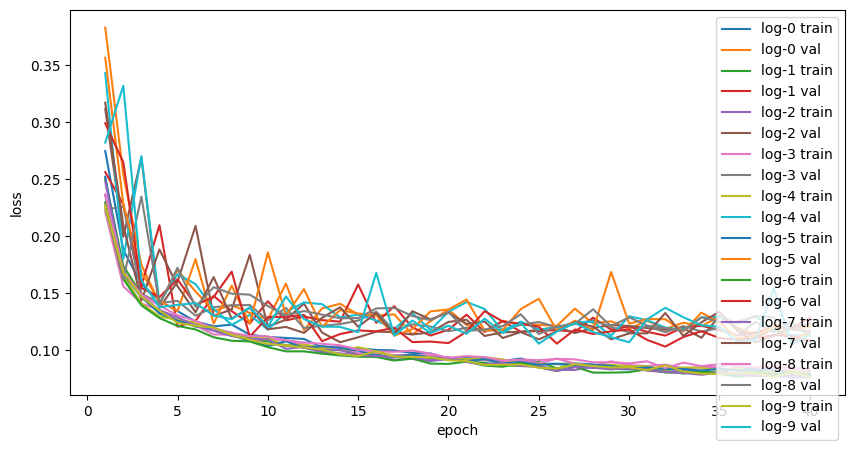

In [39]:
plot_loss(r'E:\detector_2\logs')

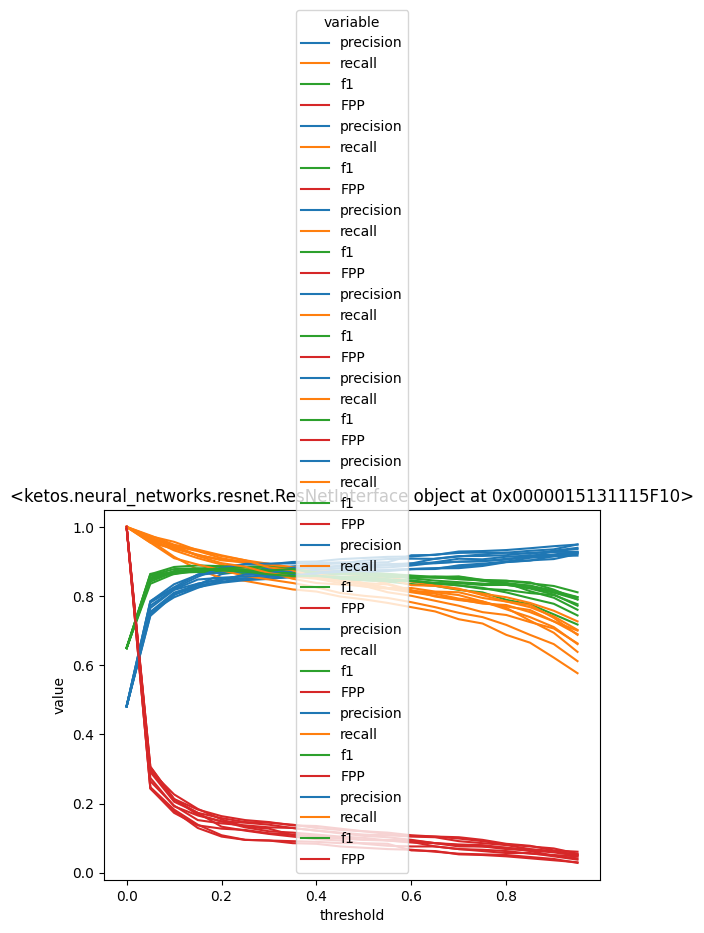

In [43]:
thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
step_size = 1.0
batch_size = 16
buffer = 0.5

# Get pathway to metrics folder
output_dir = r'E:\detector_2'
temp_folder = main_folder + '\\' + 'temp'

for idx, model in enumerate(model_names):
    
    # Open the database in read only file
    db = dbi.open_file(db_name, 'r')
    
    # Open the table in the database at the root level
    table = dbi.open_table(db, '/test')
    
    classification_csv = "classifications" + str(idx) + ".csv"
    metric_csv = "metrics"  + str(idx) + ".csv"
    stats_csv = "stats"  + str(idx) + ".csv"
    
    # Load the trained model
    model = ResNetInterface.load(model, load_audio_repr=False, new_model_folder=temp_folder)
    
    # Initialize Joint Batch Generator
    gens = []
    
    # Calculate the batch_size fixing the original batch size so there are no remainders
    batch_size = int(batch_size / sum(1 for _ in db.walk_nodes(table, "Table")))
    
    # for the testing dataset table in the database (or whatever table is passed in)
    for group in db.walk_nodes(table, "Table"):
        # Create a batch generator for this table
        generator = BatchGenerator(batch_size=batch_size, data_table=group,
                                   output_transform_func=ResNetInterface.transform_batch, shuffle=False,
                                   refresh_on_epoch_end=False, x_field='data', return_batch_ids=True)
    
        # Append the generator to the gens array
        gens.append(generator)
    
    # Create a joint batch generator if multiple tables are passed through
    gen = JointBatchGen(gens, n_batches='min', shuffle_batch=False, reset_generators=False, return_batch_ids=True)
    
    # Initialize the scores and labels
    scores = []
    labels = []
    
    # For each batch in the joint batch generator
    for batch_id in range(gen.n_batches):
        # Get the ids, spectrograms, and labels for the data in the batch
        hdf5_ids, batch_X, batch_Y = next(gen)
    
        # Get the labels for the batch data, using the "argmax" func which returns the col header, so 0 is a noise segment, 1 is a rs segment
        batch_labels = np.argmax(batch_Y, axis=1)
    
        # Returns the scores for the batch for the "positive" class - this is used in the compute detections function later on
        batch_scores = model.model.predict_on_batch(batch_X)[:, 1]
    
        # Add these scores for this batch to the overall list
        scores.extend(batch_scores)
        labels.extend(batch_labels)
    
    # Create a numpy array for the labels and scores for all batches
    labels = np.array(labels)
    scores = np.array(scores)
    
    df_groups = pd.DataFrame()
    df_stats = pd.DataFrame(columns = ['threshold', 'precision', 'recall', 'f1', 'FPP'])
    
    for threshold in thresholds:
    
        df_group = pd.DataFrame()
    
        # Compute the predictions, TP, TN, FP, and FN
        # Predicted is an array are greater than a certain threshold, 1 for the score was, 0 for it was not
        predicted, TP, TN, FP, FN = compute_detections(labels, scores, threshold)
    
        # Create the "classifications" csv file
        for group in db.walk_nodes(table, "Table"):
            df = pd.DataFrame({'id': group[:]['id'], 'filename': group[:]['filename']})
            df_group = pd.concat([df_group, df], ignore_index=True)
        df_group['threshold'] = threshold
        df_group['label'] = labels[:]
        df_group['predicted'] = predicted[:]
        df_group['score'] = scores[:]
    
        # Calculate performance metrics
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1 = 2 * precision * recall / (precision + recall)
        FPP = FP / (TN + FP)
    
        stats = [threshold, precision, recall, f1, FPP]
    
        df_groups = pd.concat([df_groups, df_group])
        df_stats.loc[len(df_stats)] = stats
    
    df_groups.to_csv(os.path.join(os.getcwd(), output_dir, classification_csv), mode='w', index=False)
    df_stats.to_csv(os.path.join(os.getcwd(), output_dir, stats_csv), mode='w', index=False)
    
    sns.lineplot(x='threshold', y='value', hue='variable', data=pd.melt(df_stats, ['threshold']))
    plt.title(model)
    
    db.close()

In [5]:
def get_batch_generator(spectro_file, audio_folder, step_size, batch_size): 
    
    audio_repr = load_audio_representation(path=spectro_file)

    spec_config = audio_repr['spectrogram']

    audio_loader = AudioFrameLoader(path=audio_folder, duration=spec_config['duration'],
                                step=step_size, stop=False, representation=spec_config['type'],
                                representation_params=spec_config, pad=False)

    batch_generator = batch_load_audio_file_data(loader=audio_loader, batch_size=batch_size)

    return batch_generator

In [6]:
def load_models(model_names, temp_folders):
    
    models = []
    for idx, model_name in enumerate(model_names):
        models.append(ResNetInterface.load(model_file=model_name, new_model_folder=temp_folders[idx]))

    return models

In [7]:
def get_detections(batch_generator, models, output_dir, threshold, raven_txt, audio_folder):
    
    detections_pos = pd.DataFrame()
    detections_neg = pd.DataFrame()

    for ibx, batch_data in enumerate(batch_generator):

        for idx, model in enumerate(models):

            # Run the model on the spectrogram data from the current batch
            batch_predictions = model.run_on_batch(batch_data['data'], return_raw_output=True)

            if idx == 0:
                # Lets store our data in a dictionary
    
                raw_output_neg = {'filename': batch_data['filename'], 'start': batch_data['start'],
                                  'end': batch_data['end'], '0-0': batch_predictions[:, 0]}
                
                raw_output_pos = {'filename': batch_data['filename'], 'start': batch_data['start'],
                                  'end': batch_data['end'], '1-0': batch_predictions[:, 1]}
    
            else:
                raw_output_neg |= {'0-' + str(idx): batch_predictions[:, 0]}
                
                raw_output_pos |= {'1-' + str(idx): batch_predictions[:, 1]}
            
        detections_pos = pd.concat([detections_pos, pd.DataFrame.from_dict(raw_output_pos)])
        detections_neg = pd.concat([detections_neg, pd.DataFrame.from_dict(raw_output_neg)])

    detections_pos.to_excel(output_dir + '\\' + 'detections-pos.xlsx', index=False)
    detections_neg.to_excel(output_dir + '\\' + 'detections-neg.xlsx', index=False)

    mean_cols_pos = detections_pos.columns[3:]
    mean_cols_neg = detections_neg.columns[3:]
    
    #detections_pos['mean-pos'] = detections_pos[mean_cols_pos].mean(axis=1)
    detections_pos['med-pos'] = detections_pos[mean_cols_pos].quantile(0.5, axis=1)
    #detections_neg['mean-neg'] = detections_neg[mean_cols_neg].mean(axis=1)
    detections_neg['med-neg'] = detections_neg[mean_cols_neg].quantile(0.5, axis=1)
    
    #merge_df = detections_pos[['filename', 'start', 'end', 'mean-pos']].copy()
    merge_df = detections_pos[['filename', 'start', 'end', 'med-pos']].copy()
    #merge_df['mean-neg'] = detections_neg['mean-neg']
    merge_df['med-neg'] = detections_neg['med-neg']
    
    scores = []
    for row in merge_df.iterrows():
        score = [row[1]['med-neg'], row[1]['med-pos']]
        #score = [row[1]['mean-neg'], row[1]['mean-pos']]
        scores.extend([score])
    
    dict = {'filename': merge_df['filename'], 'start': merge_df['start'], 'end': merge_df['end'], 'score': scores}
    
    filter_detections = filter_by_threshold(dict, threshold=threshold)
    detections_filtered = filter_by_label(filter_detections, labels=1).reset_index(drop=True)
    print(len(detections_filtered))
    detections_grp = merge_overlapping_detections(detections_filtered)
    print(len(detections_grp))
    detections_grp.to_excel(output_dir + '\\' + 'detections-filtered-and-grouped.xlsx', index=False)
    
    results_table = detections_grp
    
    cols = ['filename']
    results_table.loc[:,cols] = results_table.loc[:,cols].ffill()
    results_table['Selection'] = results_table.index +1
    results_table['View'] = 'Spectrogram 1'
    results_table['Channel'] = 1
    results_table['Begin Path'] = audio_folder + '\\' + results_table.filename
    results_table['File Offset (s)'] = results_table.start
    results_table = results_table.rename(columns={"start": "Begin Time (s)", "end": "End Time (s)", "filename": "Begin File"})
    results_table['Begin File'] = results_table['Begin File']
    results_table['Low Freq (Hz)'] = 100
    results_table['High Freq (Hz)'] = 1200
    
    results_table.to_csv(raven_txt, index=False, sep='\t')

    return detections_grp

In [49]:
model_folder = r'E:\detector_2\models'

model_names = [model_folder + '\\' + 'rs-model-0.kt', model_folder + '\\' + 'rs-model-1.kt', model_folder + '\\' + 'rs-model-2.kt', 
              model_folder + '\\' + 'rs-model-3.kt', model_folder + '\\' + 'rs-model-4.kt', model_folder + '\\' + 'rs-model-5.kt',
              model_folder + '\\' + 'rs-model-6.kt', model_folder + '\\' + 'rs-model-7.kt', model_folder + '\\' + 'rs-model-8.kt',
              model_folder + '\\' + 'rs-model-9.kt']

temp_folders = [model_folder + '\\' + 'rs-temp-0', model_folder + '\\' + 'rs-temp-1', model_folder + '\\' + 'rs-temp-2', model_folder + '\\' + 'rs-temp-3', model_folder + '\\' + 'rs-temp-4',
               model_folder + '\\' + 'rs-temp-5', model_folder + '\\' + 'rs-temp-6', model_folder + '\\' + 'rs-temp-7', model_folder + '\\' + 'rs-temp-8', model_folder + '\\' + 'rs-temp-9']


audio_folder = r'D:\ringed-seal-data\Ulu_2024'

# Threshold
threshold = 0.5

# Step 0.5s each time (overlap of 50% for 1 sec duration)
step_size = 0.5

# Number of samples in batch
batch_size = 16

output_dir = r'E:\detector_2\output'
detections_csv = output_dir + '\\' + 'detections-avg.csv'
temp_folder = output_dir + '\\' + 'ringedS_tmp_folder'
pos_detection = output_dir + '\\' + 'grouped-filtered-dets.xlsx'
raven_txt = output_dir + '\\' + 'raven-formatted-detections.txt'

In [48]:
batch_generator = get_batch_generator(spectro_file, audio_folder, step_size, batch_size)
all_models = load_models(model_names, temp_folders)
detections_grp = get_detections(batch_generator, all_models, output_dir, threshold, raven_txt, audio_folder)

  0%|                                                                                          | 0/750 [00:00<?, ?it/s]RuntimeWarning: Waveform padded with its own reflection to achieve required length to compute the stft. 46 samples were padded on the left and 0 samples were padded on the right


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [03:08<00:00,  3.97it/s]


2763
1234


In [10]:
model_folder = r'E:\detector_2\models'

spectro_file = r'E:\detector_2\spec_config_100-1200Hz-0.032-hamm-normalized.json'

model_names = [model_folder + '\\' + 'rs-model-0.kt', model_folder + '\\' + 'rs-model-1.kt', model_folder + '\\' + 'rs-model-2.kt', 
              model_folder + '\\' + 'rs-model-3.kt', model_folder + '\\' + 'rs-model-4.kt', model_folder + '\\' + 'rs-model-5.kt',
              model_folder + '\\' + 'rs-model-6.kt', model_folder + '\\' + 'rs-model-7.kt', model_folder + '\\' + 'rs-model-8.kt',
              model_folder + '\\' + 'rs-model-9.kt']

temp_folders = [model_folder + '\\' + 'rs-temp-0', model_folder + '\\' + 'rs-temp-1', model_folder + '\\' + 'rs-temp-2', model_folder + '\\' + 'rs-temp-3', model_folder + '\\' + 'rs-temp-4',
               model_folder + '\\' + 'rs-temp-5', model_folder + '\\' + 'rs-temp-6', model_folder + '\\' + 'rs-temp-7', model_folder + '\\' + 'rs-temp-8', model_folder + '\\' + 'rs-temp-9']


audio_folder = r'E:\detector_2\pp-audio'

# Threshold
threshold = 0.5

# Step 0.5s each time (overlap of 50% for 1 sec duration)
step_size = 0.5

# Number of samples in batch
batch_size = 16

output_dir = r'E:\detector_2\output'
detections_csv = output_dir + '\\' + 'detections-avg-pp.csv'
temp_folder = output_dir + '\\' + 'ringedS_tmp_folder-pp'
pos_detection = output_dir + '\\' + 'grouped-filtered-dets-pp.xlsx'
raven_txt = output_dir + '\\' + 'raven-formatted-detections-pp.txt'

In [11]:
batch_generator = get_batch_generator(spectro_file, audio_folder, step_size, batch_size)
all_models = load_models(model_names, temp_folders)
detections_grp = get_detections(batch_generator, all_models, output_dir, threshold, raven_txt, audio_folder)

  0%|                                                                                          | 0/748 [00:00<?, ?it/s]RuntimeWarning: Waveform padded with its own reflection to achieve required length to compute the stft. 46 samples were padded on the left and 0 samples were padded on the right


100%|████████████████████████████████████████████████████████████████████████████████| 748/748 [03:17<00:00,  3.78it/s]


698
232


In [12]:
model_folder = r'E:\detector_2\models'

spectro_file = r'E:\detector_2\spec_config_100-1200Hz-0.032-hamm-normalized.json'

model_names = [model_folder + '\\' + 'rs-model-0.kt', model_folder + '\\' + 'rs-model-1.kt', model_folder + '\\' + 'rs-model-2.kt', 
              model_folder + '\\' + 'rs-model-3.kt', model_folder + '\\' + 'rs-model-4.kt', model_folder + '\\' + 'rs-model-5.kt',
              model_folder + '\\' + 'rs-model-6.kt', model_folder + '\\' + 'rs-model-7.kt', model_folder + '\\' + 'rs-model-8.kt',
              model_folder + '\\' + 'rs-model-9.kt']

temp_folders = [model_folder + '\\' + 'rs-temp-0', model_folder + '\\' + 'rs-temp-1', model_folder + '\\' + 'rs-temp-2', model_folder + '\\' + 'rs-temp-3', model_folder + '\\' + 'rs-temp-4',
               model_folder + '\\' + 'rs-temp-5', model_folder + '\\' + 'rs-temp-6', model_folder + '\\' + 'rs-temp-7', model_folder + '\\' + 'rs-temp-8', model_folder + '\\' + 'rs-temp-9']


audio_folder = r'E:\detector_2\Ulu-2024-noRS'

# Threshold
threshold = 0.5

# Step 0.5s each time (overlap of 50% for 1 sec duration)
step_size = 0.5

# Number of samples in batch
batch_size = 16

output_dir = r'E:\detector_2\output'
detections_csv = output_dir + '\\' + 'detections-avg-ulu24.csv'
temp_folder = output_dir + '\\' + 'ringedS_tmp_folder-ulu24'
pos_detection = output_dir + '\\' + 'grouped-filtered-dets-ulu24.xlsx'
raven_txt = output_dir + '\\' + 'raven-formatted-detections-ulu24.txt'

In [13]:
batch_generator = get_batch_generator(spectro_file, audio_folder, step_size, batch_size)
all_models = load_models(model_names, temp_folders)
detections_grp = get_detections(batch_generator, all_models, output_dir, threshold, raven_txt, audio_folder)

100%|████████████████████████████████████████████████████████████████████████████████| 973/973 [04:10<00:00,  3.88it/s]


789
282
